# Astro 503 HW2 --- Achintya Krishnan

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import simpson
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [3]:
#!wget http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat

In [4]:
data = at.Table.read('aless_average_seds.dat', format='ascii', names=['wave (microns)','fnu (mJy)', 'fnu_bright', 'fnu_faint'], data_start=1)
wave_microns = data["wave (microns)"]*u.micron
freq_GHz = wave_microns.to(u.GHz, equivalencies=u.spectral())
data["freq (GHz)"] = freq_GHz.value

Note that the observed flux density at frequency $\nu_0$ is given by the following:

$$F_{\nu}(\nu_0) = \frac{L_{\nu}(\nu_0(1+z))}{4\pi D_L^2}(1+z)$$


If we are to evaluate this at a luminosity distance of 10 pc (i.e. where $z\approx 0$), we get:

$$F_{\nu}(\nu_0)|_{D_L = 10pc} = \frac{L_{\nu}(\nu_0)}{4\pi (10pc)^2}$$

Dividing $F_{\nu}(\nu_0)$ by $F_{\nu}(\nu_0)|_{D_L = 10pc}$ gives:

$$\frac{F_{\nu}(\nu_0)}{F_{\nu}(\nu_0)|_{D_L = 10pc}} = \frac{L_{\nu}(\nu_0(1+z))}{L_\nu(\nu_0)(D_L/10pc)^2}(1+z)$$

The ratio of luminosities is equal to the ratio of rest-frame fluxes (just divide the luminosities in numerator and denominator by $4\pi(10pc)^2$ -- a common factor which cancels out). So, we can rewrite the above equation as (note: using $f$ to represent rest-frame SED and $F$ to represent observed SED for source at redshift z):

$$\frac{F_{\nu}(\nu_0)}{F_{\nu}(\nu_0)|_{D_L = 10pc}} = \frac{f_{\nu}(\nu_0(1+z))}{f_\nu(\nu_0)(D_L/10pc)^2}(1+z)$$

But, the rest-frame SED is just the observed SED if the source were at a distance of 10 pc. In other words, $F_{\nu}(\nu_0)|_{D_L = 10pc} = f_\nu(\nu_0)$. Therefore, we can cancel the denominators on both sides of the equality to get:

\begin{equation}
\boxed{
F_{\nu}(\nu_0) = \frac{f_{\nu}(\nu_0(1+z))}{(D_L/10pc)^2}(1+z)}
\end{equation}

We will use this result extensively in the rest of problem 1.

### Figure 1

In [5]:
def RedshiftedFnuInBand(filtCenter_wlen, zvals, dataTable):
    # Enter central wavelength in as numpy scalar in units of microns
        # but don't add in astropy units, function does this below
    # zvals = redshifts to evaluate at      
    # dataTable = table with rest frame SED of galaxy
    
    filtCenter_wlen = filtCenter_wlen*u.micron   # microns
    bandwidth = 3*u.micron      # microns
    
    filt_max_wlen = filtCenter_wlen + bandwidth/2  # max wlen of filter
    filt_min_freq = filt_max_wlen.to(u.GHz, equivalencies=u.spectral())  # min freq of filter in GHz
    
    filt_min_wlen = filtCenter_wlen - bandwidth/2    # min wlen of filter
    filt_max_freq = filt_min_wlen.to(u.GHz, equivalencies=u.spectral())    # max freq of filter in GHz
    
    
    Fnu_obs = []        # create empty list to house avg flux density in "un-redshifted band" vs. z
    for z in zvals:
        DL = cosmo.luminosity_distance(z).to(u.dapc)   # luminosity distance converted to decaparsecs
        redshifted_freq = np.array(np.flip(dataTable["freq (GHz)"]/(1+z)))
        redshifted_fluxes = np.array(np.flip(dataTable["fnu (mJy)"]*(1+z) / (DL.value)**2))
        
        obs_band_freq=np.linspace(filt_min_freq.value, filt_max_freq.value, num=51)  # obs freq band
        Fnu_obs_vec = np.interp(x=obs_band_freq, xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
        Fnu_obs_val = simpson(y=Fnu_obs_vec/obs_band_freq, x=obs_band_freq)  # units = mJy
            # redshift the SED
            # interpolate redshifted SED values across linspace spanning observing bandpass
            # need to flip arrays for xp and fp so that freq array entered in increasing order
            # then integrate via Simpson's method to get flux density across observing band
                # we integrate the flux density divided by nu across the observing band
                # integral of just flux density (i.e. no division by nu) would give us total flux in band, NOT flux density
                # so integral of flux density / nu over the band returns average flux density across band
        Fnu_obs.append(Fnu_obs_val)
    
    Fnu_obs = np.array(Fnu_obs)  # convert to np array

    return Fnu_obs   # calculate Fnu_obs in mJy

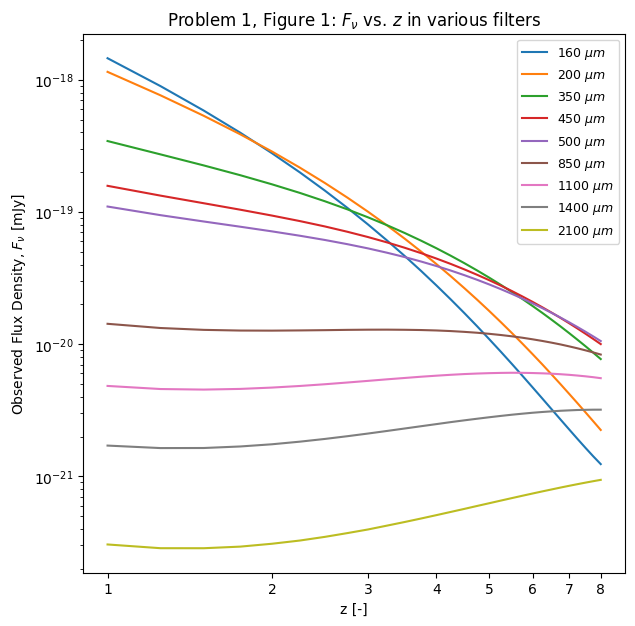

In [6]:
fig11,ax11 = plt.subplots(1)
fig11.set_figheight(7)
fig11.set_figwidth(7)
ax11.set_title(r'Problem 1, Figure 1: $F_{\nu}$ vs. $z$ in various filters')
ax11.set_xlabel('z [-]')
ax11.set_ylabel(r'Observed Flux Density, $F_{\nu}$ [mJy]')
ax11.set_xscale('log')
ax11.set_yscale('log')
ax11.set_xticks(ticks=[1,2,3,4,5,6,7,8], labels=[1,2,3,4,5,6,7,8])

z_ls=np.linspace(1,8,29)  # grid of redshift 1-->8 (inclusive) with 0.25 spacing

for wlen in [160,200,350,450, 500, 850, 1100, 1400, 2100]:
    Fnuobs = RedshiftedFnuInBand(filtCenter_wlen=wlen, zvals=z_ls, dataTable=data)   
    ax11.plot(z_ls, Fnuobs, label=str(wlen)+' $\mu m$')
    
ax11.legend(loc='upper right', fontsize=9)

### Figure 2

In [7]:
# read in BICEP filters and convert their wavelength columns (in Angs) to microns
BICEP95 = at.Table.read('BICEP_BICEP2.95GHz_rj.dat', format='ascii', names = ['wave (A)', 'transmission'])
BICEP95["wave (microns)"] = ((BICEP95["wave (A)"]*u.AA).to(u.micron)).value
BICEP150 = at.Table.read('BICEP_BICEP2.150GHz_rj.dat', format='ascii', names = ['wave (A)', 'transmission'])
BICEP150["wave (microns)"] = ((BICEP150["wave (A)"]*u.AA).to(u.micron)).value
BICEP220 = at.Table.read('BICEP_BICEP2.220GHz_rj.dat', format='ascii', names = ['wave (A)', 'transmission'])
BICEP220["wave (microns)"] = ((BICEP220["wave (A)"]*u.AA).to(u.micron)).value

(950.9276626500001, 4588.660071450001)

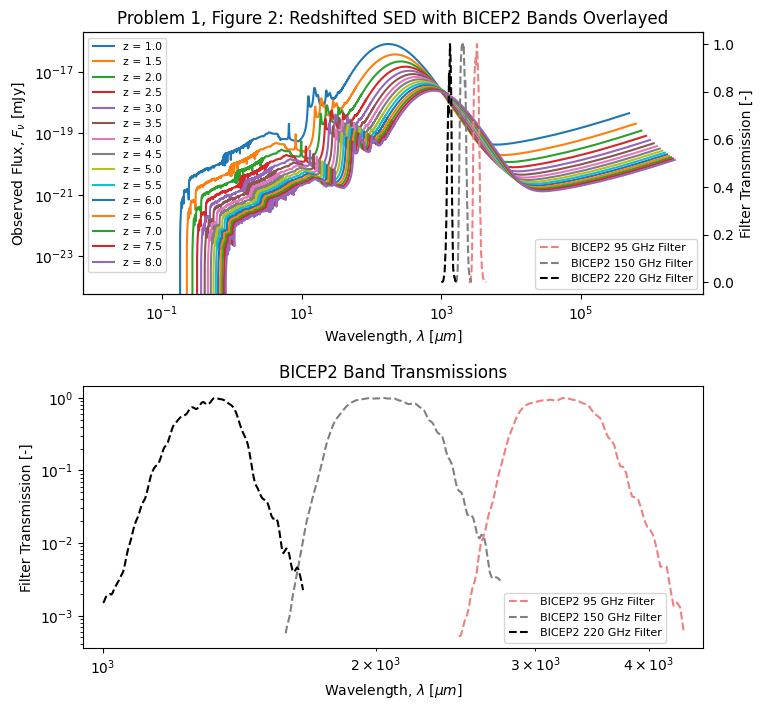

In [8]:
fig12,ax12 = plt.subplots(nrows=2, ncols=1)
fig12.set_figheight(8)
fig12.set_figwidth(8)
plt.subplots_adjust(hspace=0.35)

# Plot redshifted SEDs with BICEP2 filters overlayed
ax12b = ax12[0].twinx()
ax12[0].set_xscale('log')
ax12[0].set_yscale('log')

z_ls2 = np.linspace(1,8,15)   # question says to use same redshift range but can space by 0.5 now
for zfig2 in z_ls2:
    DL = cosmo.luminosity_distance(zfig2).to(u.dapc)   # luminosity distance converted to decaparsecs
    redshifted_wlens = data["wave (microns)"] * (1+zfig2)   # redshift the wavlengths
    redshifted_fluxes = data["fnu (mJy)"] * (1+zfig2) / DL.value**2  # redshift the flux density
    
    ax12[0].plot(redshifted_wlens, redshifted_fluxes, label='z = '+str(zfig2))  # plot SED at given z

# Plot BICEP2 filters
ax12b.plot(BICEP95["wave (microns)"], BICEP95["transmission"], label='BICEP2 95 GHz Filter', ls='--', 
           color='lightcoral')
ax12b.plot(BICEP150["wave (microns)"], BICEP150["transmission"], label='BICEP2 150 GHz Filter', ls='--', 
              color='gray')
ax12b.plot(BICEP220["wave (microns)"], BICEP220["transmission"], label='BICEP2 220 GHz Filter', ls='--', 
           color='black')

ax12[0].set_title('Problem 1, Figure 2: Redshifted SED with BICEP2 Bands Overlayed')
ax12[0].set_ylabel(r'Observed Flux, $F_{\nu}$ [mJy]')
ax12b.set_ylabel('Filter Transmission [-]')
ax12[0].set_xlabel(r'Wavelength, $\lambda$ [$\mu m$]')
ax12[0].legend(fontsize=7.8)
ax12b.legend(loc='lower right', fontsize=8)

###############################
# Plot zoomed in view of BICEP2 filters
ax12[1].set_xscale('log')
ax12[1].set_yscale('log')

# Plot BICEP2 filters
ax12[1].plot(BICEP95["wave (microns)"], BICEP95["transmission"], label='BICEP2 95 GHz Filter', ls='--', 
           color='lightcoral')
ax12[1].plot(BICEP150["wave (microns)"], BICEP150["transmission"], label='BICEP2 150 GHz Filter', ls='--', 
              color='gray')
ax12[1].plot(BICEP220["wave (microns)"], BICEP220["transmission"], label='BICEP2 220 GHz Filter', ls='--', 
           color='black')

ax12[1].set_title('BICEP2 Band Transmissions')
ax12[1].set_ylabel('Filter Transmission [-]')
ax12[1].set_xlabel(r'Wavelength, $\lambda$ [$\mu m$]')
ax12[1].legend(loc='lower right', bbox_to_anchor=(0.45,0,0.5,0.5), fontsize=8)
ax12[1].set_xlim(min(BICEP220["wave (microns)"])*0.95, max(BICEP95["wave (microns)"])*1.05)  # zoom in on BICEP filters

### Figure 3

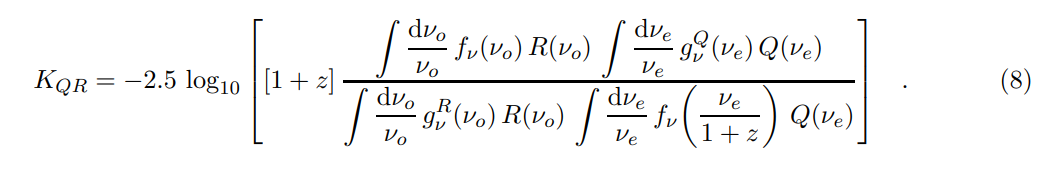

Equation 8 from Hogg, et al. (2002). $f_{\nu}$ is the apparent SED --- not the intrinsic one which is given to us in the aless data. Also, divide by 1+z instead of multiplying by 1+z in formula (I have no idea why).

In [9]:
#Read in LSST filters
LSSTu_filt = ascii.read("LSST_LSST.u_filter.dat", names=['wlen (Angs)', 'transmission'])
LSSTu_filt["freq (GHz)"] = ((LSSTu_filt["wlen (Angs)"]*u.AA).to(u.GHz, equivalencies=u.spectral())).value

LSSTg_filt = ascii.read("LSST_LSST.g_filter.dat", names=['wlen (Angs)', 'transmission'])
LSSTg_filt["freq (GHz)"] = ((LSSTg_filt["wlen (Angs)"]*u.AA).to(u.GHz, equivalencies=u.spectral())).value

LSSTr_filt = ascii.read("LSST_LSST.r_filter.dat", names=['wlen (Angs)', 'transmission'])
LSSTr_filt["freq (GHz)"] = ((LSSTr_filt["wlen (Angs)"]*u.AA).to(u.GHz, equivalencies=u.spectral())).value

LSSTi_filt = ascii.read("LSST_LSST.i_filter.dat", names=['wlen (Angs)', 'transmission'])
LSSTi_filt["freq (GHz)"] = ((LSSTi_filt["wlen (Angs)"]*u.AA).to(u.GHz, equivalencies=u.spectral())).value

LSSTz_filt = ascii.read("LSST_LSST.z_filter.dat", names=['wlen (Angs)', 'transmission'])
LSSTz_filt["freq (GHz)"] = ((LSSTz_filt["wlen (Angs)"]*u.AA).to(u.GHz, equivalencies=u.spectral())).value

LSSTy_filt = ascii.read("LSST_LSST.y_filter.dat", names=['wlen (Angs)', 'transmission'])
LSSTy_filt["freq (GHz)"] = ((LSSTy_filt["wlen (Angs)"]*u.AA).to(u.GHz, equivalencies=u.spectral())).value

In [10]:
# Get min and max frequencies of LSST filters in GHz
min_freq_LSSTu = min(LSSTu_filt["freq (GHz)"])*u.GHz
max_freq_LSSTu = max(LSSTu_filt["freq (GHz)"])*u.GHz

min_freq_LSSTg = min(LSSTg_filt["freq (GHz)"])*u.GHz
max_freq_LSSTg = max(LSSTg_filt["freq (GHz)"])*u.GHz

min_freq_LSSTr = min(LSSTr_filt["freq (GHz)"])*u.GHz
max_freq_LSSTr = max(LSSTr_filt["freq (GHz)"])*u.GHz

min_freq_LSSTi = min(LSSTi_filt["freq (GHz)"])*u.GHz
max_freq_LSSTi = max(LSSTi_filt["freq (GHz)"])*u.GHz

min_freq_LSSTu = min(LSSTu_filt["freq (GHz)"])*u.GHz
max_freq_LSSTu = max(LSSTu_filt["freq (GHz)"])*u.GHz

min_freq_LSSTz = min(LSSTz_filt["freq (GHz)"])*u.GHz
max_freq_LSSTz = max(LSSTz_filt["freq (GHz)"])*u.GHz

min_freq_LSSTy = min(LSSTy_filt["freq (GHz)"])*u.GHz
max_freq_LSSTy = max(LSSTy_filt["freq (GHz)"])*u.GHz

In [11]:
# LSST g filter
z_ls3 = np.linspace(0,2,num=201)    # range of redshifts to plot K correction over
KQR_g = []

for zfig3 in z_ls3:
    # SED we're given is in rest frame (10 pc distance)
    # need apparent SED (i.e. redshift it)
    redshifted_freq = np.flip(np.array(data["freq (GHz)"] / (1+zfig3)))
    DLfig3 = cosmo.luminosity_distance(zfig3).to(u.dapc)  # luminosity distance converted to decaparsecs
    redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
    
    # Do filter matching
    # Given observing frame band, need to find which LSST filter best matches emission/rest frame (i.e. unredshifted band)
    min_freq_unredshifted_LSSTg = min_freq_LSSTg.value * (1+zfig3)
    max_freq_unredshifted_LSSTg = max_freq_LSSTg.value * (1+zfig3)
    
    # if we've unredshifted g band beyond/outside of u band, can't calculate K correction with LSST filters (so don't)
    if min_freq_unredshifted_LSSTg > max_freq_LSSTu.value:
        KQR_g.append(np.nan)
    else:
        # Amnt of overlap = abs(difference btwn left ends) + abs(difference btwn right ends)
            # pick LSST filter with biggest overlap
        overlapU = np.abs(min_freq_LSSTu.value-min_freq_unredshifted_LSSTg) + np.abs(max_freq_LSSTu.value-max_freq_unredshifted_LSSTg)
        overlapG = np.abs(min_freq_LSSTg.value-min_freq_unredshifted_LSSTg) + np.abs(max_freq_LSSTg.value-max_freq_unredshifted_LSSTg)
        overlapR = np.abs(min_freq_LSSTr.value-min_freq_unredshifted_LSSTg) + np.abs(max_freq_LSSTr.value-max_freq_unredshifted_LSSTg)
        overlapI = np.abs(min_freq_LSSTi.value-min_freq_unredshifted_LSSTg) + np.abs(max_freq_LSSTi.value-max_freq_unredshifted_LSSTg)
        overlapZ = np.abs(min_freq_LSSTz.value-min_freq_unredshifted_LSSTg) + np.abs(max_freq_LSSTz.value-max_freq_unredshifted_LSSTg)
        overlapY = np.abs(min_freq_LSSTy.value-min_freq_unredshifted_LSSTg) + np.abs(max_freq_LSSTy.value-max_freq_unredshifted_LSSTg)
        
        # in order u,g,r,i,z,y
        overlaps = np.array([overlapU, overlapG, overlapR, overlapI, overlapZ, overlapY])
        filterInd = np.argmin(overlaps)
        
        if filterInd == 0:   # Q=u
            Q_of_nu_e = LSSTu_filt["transmission"]
            nu_e = LSSTu_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 1:    # Q=g
            Q_of_nu_e = LSSTg_filt["transmission"]
            nu_e = LSSTg_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 2:     # Q=r
            Q_of_nu_e = LSSTr_filt["transmission"]
            nu_e = LSSTr_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 3:     # Q=i
            Q_of_nu_e = LSSTi_filt["transmission"]
            nu_e = LSSTi_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 4:     #Q=z
            Q_of_nu_e = LSSTz_filt["transmission"]
            nu_e = LSSTz_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 5:    #Q=y
            Q_of_nu_e = LSSTy_filt["transmission"]
            nu_e = LSSTy_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)   
            
        nu0 = LSSTg_filt["freq (GHz)"]
        f_of_nu0 = np.interp(x=nu0, xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
        R_of_nu0 = LSSTg_filt["transmission"]
        
        topLeftInt = simpson(y=f_of_nu0 * R_of_nu0 / nu0, x=nu0)
        botLeftInt = simpson(y=R_of_nu0 / nu0, x=nu0)
        topRightInt = simpson(y=Q_of_nu_e / nu_e, x=nu_e)
        botRightInt = simpson(y=Q_of_nu_e * f_nue_by_1pz / nu_e, x=nu_e)
        
        KQR_g.append(-2.5*np.log10(topLeftInt * topRightInt / botLeftInt / botRightInt / (1+zfig3)))

C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\3166942188.py:10: RuntimeWarning: divide by zero encountered in divide
  redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\3166942188.py:10: RuntimeWarning: invalid value encountered in divide
  redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
C:\Users\iamac\anaconda3\lib\site-packages\scipy\integrate\_quadrature.py:808: RuntimeWarning: invalid value encountered in scalar subtract
  result += alpha*y[slice1] + beta*y[slice2] - eta*y[slice3]


In [12]:
# LSST i filter
KQR_i = []

for zfig3 in z_ls3:
    # SED we're given is in rest frame (10 pc distance)
    # need apparent SED (i.e. redshift it)
    redshifted_freq = np.flip(np.array(data["freq (GHz)"] / (1+zfig3)))
    DLfig3 = cosmo.luminosity_distance(zfig3).to(u.dapc)  # luminosity distance converted to decaparsecs
    redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
    
    # Do filter matching
    # Given observing frame band, need to find which LSST filter best matches emission/rest frame (i.e. unredshifted band)
    min_freq_unredshifted_LSSTi = min_freq_LSSTi.value * (1+zfig3)
    max_freq_unredshifted_LSSTi = max_freq_LSSTi.value * (1+zfig3)
    
    # if we've unredshifted g band beyond/outside of u band, can't calculate K correction with LSST filters (so don't)
    if min_freq_unredshifted_LSSTi > max_freq_LSSTu.value:
        KQR_i.append(np.nan)
    else:
        # Amnt of overlap = abs(difference btwn left ends) + abs(difference btwn right ends)
            # pick LSST filter with biggest overlap
        overlapU = np.abs(min_freq_LSSTu.value-min_freq_unredshifted_LSSTi) + np.abs(max_freq_LSSTu.value-max_freq_unredshifted_LSSTi)
        overlapG = np.abs(min_freq_LSSTg.value-min_freq_unredshifted_LSSTi) + np.abs(max_freq_LSSTg.value-max_freq_unredshifted_LSSTi)
        overlapR = np.abs(min_freq_LSSTr.value-min_freq_unredshifted_LSSTi) + np.abs(max_freq_LSSTr.value-max_freq_unredshifted_LSSTi)
        overlapI = np.abs(min_freq_LSSTi.value-min_freq_unredshifted_LSSTi) + np.abs(max_freq_LSSTi.value-max_freq_unredshifted_LSSTi)
        overlapZ = np.abs(min_freq_LSSTz.value-min_freq_unredshifted_LSSTi) + np.abs(max_freq_LSSTz.value-max_freq_unredshifted_LSSTi)
        overlapY = np.abs(min_freq_LSSTy.value-min_freq_unredshifted_LSSTi) + np.abs(max_freq_LSSTy.value-max_freq_unredshifted_LSSTi)
        
        # in order u,g,r,i,z,y
        overlaps = np.array([overlapU, overlapG, overlapR, overlapI, overlapZ, overlapY])
        filterInd = np.argmin(overlaps)
        
        if filterInd == 0:   # Q=u
            Q_of_nu_e = LSSTu_filt["transmission"]
            nu_e = LSSTu_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 1:    # Q=g
            Q_of_nu_e = LSSTg_filt["transmission"]
            nu_e = LSSTg_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 2:     # Q=r
            Q_of_nu_e = LSSTr_filt["transmission"]
            nu_e = LSSTr_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 3:     # Q=i
            Q_of_nu_e = LSSTi_filt["transmission"]
            nu_e = LSSTi_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 4:     #Q=z
            Q_of_nu_e = LSSTz_filt["transmission"]
            nu_e = LSSTz_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 5:    #Q=y
            Q_of_nu_e = LSSTy_filt["transmission"]
            nu_e = LSSTy_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)   
            
        nu0 = LSSTi_filt["freq (GHz)"]
        f_of_nu0 = np.interp(x=nu0, xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
        R_of_nu0 = LSSTi_filt["transmission"]
        
        topLeftInt = simpson(y=f_of_nu0 * R_of_nu0 / nu0, x=nu0)
        botLeftInt = simpson(y=R_of_nu0 / nu0, x=nu0)
        topRightInt = simpson(y=Q_of_nu_e / nu_e, x=nu_e)
        botRightInt = simpson(y=Q_of_nu_e * f_nue_by_1pz / nu_e, x=nu_e)
        
        KQR_i.append(-2.5*np.log10(topLeftInt * topRightInt / botLeftInt / botRightInt / (1+zfig3)))

C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\3623068211.py:9: RuntimeWarning: divide by zero encountered in divide
  redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\3623068211.py:9: RuntimeWarning: invalid value encountered in divide
  redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))


In [13]:
# LSST y filter  -- eqn 8
z_ls3 = np.linspace(0,2,num=201)    # range of redshifts to plot K correction over
KQR_y = []

for zfig3 in z_ls3:
    # SED we're given is in rest frame (10 pc distance)
    # need apparent SED (i.e. redshift it)
    redshifted_freq = np.flip(np.array(data["freq (GHz)"] / (1+zfig3)))
    DLfig3 = cosmo.luminosity_distance(zfig3).to(u.dapc)  # luminosity distance converted to decaparsecs
    redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
    
    # Do filter matching
    # Given observing frame band, need to find which LSST filter best matches emission/rest frame (i.e. unredshifted band)
    min_freq_unredshifted_LSSTy = min_freq_LSSTy.value * (1+zfig3)
    max_freq_unredshifted_LSSTy = max_freq_LSSTy.value * (1+zfig3)
    
    # if we've unredshifted g band beyond/outside of u band, can't calculate K correction with LSST filters (so don't)
    if min_freq_unredshifted_LSSTy > max_freq_LSSTu.value:
        KQR_y.append(np.nan)
    else:
        # Amnt of overlap = abs(difference btwn left ends) + abs(difference btwn right ends)
            # pick LSST filter with biggest overlap
        overlapU = np.abs(min_freq_LSSTu.value-min_freq_unredshifted_LSSTy) + np.abs(max_freq_LSSTu.value-max_freq_unredshifted_LSSTy)
        overlapG = np.abs(min_freq_LSSTg.value-min_freq_unredshifted_LSSTy) + np.abs(max_freq_LSSTg.value-max_freq_unredshifted_LSSTy)
        overlapR = np.abs(min_freq_LSSTr.value-min_freq_unredshifted_LSSTy) + np.abs(max_freq_LSSTr.value-max_freq_unredshifted_LSSTy)
        overlapI = np.abs(min_freq_LSSTi.value-min_freq_unredshifted_LSSTy) + np.abs(max_freq_LSSTi.value-max_freq_unredshifted_LSSTy)
        overlapZ = np.abs(min_freq_LSSTz.value-min_freq_unredshifted_LSSTy) + np.abs(max_freq_LSSTz.value-max_freq_unredshifted_LSSTy)
        overlapY = np.abs(min_freq_LSSTy.value-min_freq_unredshifted_LSSTy) + np.abs(max_freq_LSSTy.value-max_freq_unredshifted_LSSTy)
        
        # in order u,g,r,i,z,y
        overlaps = np.array([overlapU, overlapG, overlapR, overlapI, overlapZ, overlapY])
        filterInd = np.argmin(overlaps)
        
        if filterInd == 0:   # Q=u
            Q_of_nu_e = LSSTu_filt["transmission"]
            nu_e = LSSTu_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 1:    # Q=g
            Q_of_nu_e = LSSTg_filt["transmission"]
            nu_e = LSSTg_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 2:     # Q=r
            Q_of_nu_e = LSSTr_filt["transmission"]
            nu_e = LSSTr_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 3:     # Q=i
            Q_of_nu_e = LSSTi_filt["transmission"]
            nu_e = LSSTi_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 4:     #Q=z
            Q_of_nu_e = LSSTz_filt["transmission"]
            nu_e = LSSTz_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
            
        elif filterInd == 5:    #Q=y
            Q_of_nu_e = LSSTy_filt["transmission"]
            nu_e = LSSTy_filt["freq (GHz)"]
            f_nue_by_1pz = np.interp(x=nu_e/(1+zfig3), xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)   
            
        nu0 = LSSTy_filt["freq (GHz)"]
        f_of_nu0 = np.interp(x=nu0, xp=redshifted_freq, fp=redshifted_fluxes, left=0, right=0)
        R_of_nu0 = LSSTy_filt["transmission"]
        
        topLeftInt = simpson(y=f_of_nu0 * R_of_nu0 / nu0, x=nu0)
        botLeftInt = simpson(y=R_of_nu0 / nu0, x=nu0)
        topRightInt = simpson(y=Q_of_nu_e / nu_e, x=nu_e)
        botRightInt = simpson(y=Q_of_nu_e * f_nue_by_1pz / nu_e, x=nu_e)
        
        KQR_y.append(-2.5*np.log10(topLeftInt * topRightInt / botLeftInt / botRightInt / (1+zfig3)))

C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\774340069.py:10: RuntimeWarning: divide by zero encountered in divide
  redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\774340069.py:10: RuntimeWarning: invalid value encountered in divide
  redshifted_fluxes = np.flip(np.array(data["fnu (mJy)"] * (1+zfig3) / (DLfig3.value)**2))
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\774340069.py:68: RuntimeWarning: invalid value encountered in multiply
  topLeftInt = simpson(y=f_of_nu0 * R_of_nu0 / nu0, x=nu0)
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\774340069.py:71: RuntimeWarning: invalid value encountered in multiply
  botRightInt = simpson(y=Q_of_nu_e * f_nue_by_1pz / nu_e, x=nu_e)


Text(0.5, 1.0, 'Problem 1, Figure 3: K-correction vs. z in LSST g,i,y bands')

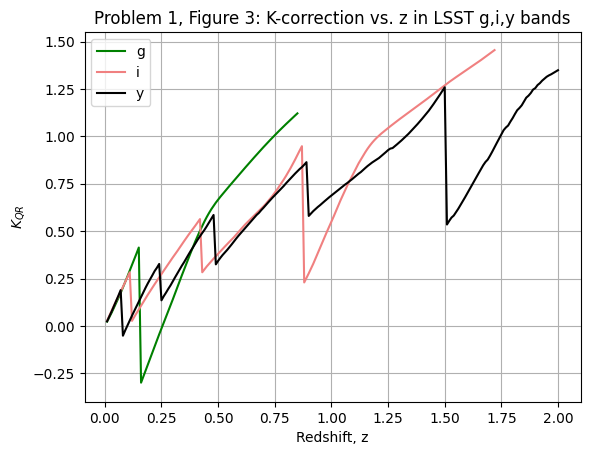

In [14]:
# Plot the results for g,i,y bands on same plot
plt.plot(z_ls3, KQR_g, label='g', color='green')
plt.plot(z_ls3,KQR_i, label='i', color='lightcoral')
plt.plot(z_ls3, KQR_y, label='y', color='black')
plt.grid('True')
plt.ylim(-0.4,1.55)
plt.legend()
plt.ylabel(r'$K_{QR}$')
plt.xlabel('Redshift, z')
plt.title('Problem 1, Figure 3: K-correction vs. z in LSST g,i,y bands')

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

### The short-answer questions asked in the cell above are answered at the bottom of this notebook (just above cell saying "Divide and conquer").

In [15]:
### Function to do all of problem 2 plots/calculations
def DoProblem2(N):
    # Make all plots/do all calculations required in problem 3 for a sample size N of SNe
    
    np.random.seed(1000)   # set seed
    
    # Randomly drawing the three spherical coordinates from a uniform distribution of the appropriate size 
    # truly does uniformly generate supernovae throughout a sphere
    rand_dist = np.random.uniform(low=0, high=2500, size=N)    # Mpc, ith element ===> ith supernovae's distance from us
    rand_azim = np.random.uniform(low=0, high=2*np.pi, size=N)  # radians, ith element ===> ith supernovae's azimuthal angle
    rand_polar = np.random.uniform(low=0, high=np.pi, size=N)   # radians, ith element ===> ith supernovae's polar angle

    mean_SNdist = np.mean(rand_dist)  ## average distance for supernovae
    print('The mean true distance of the supernovae is '+str(round(mean_SNdist,2))+' Mpc.')
    
    Gauss_corrections = np.random.normal(loc=0.0, scale=1.0, size=N)  # Gaussian absolute magnitude corrections
    absMags = -19. + Gauss_corrections        # absolute magnitudes of the 100 supernovae

    appMags = absMags + 5*np.log10(rand_dist*10**6/10)   # calculate apparent magnitudes, convert distance [Mpc] to decaparsecs

    # Put spherical coordinates, distance, absMags, and appMags into dataframe
    SN_df = pd.DataFrame({
        'distance [Mpc]': rand_dist,
        'azimuthal angle [rad]': rand_azim, 
        'polar angle [rad]': rand_polar, 
        'Abs Mag': absMags,
        'App Mag': appMags,
    })

    # Separate into 2 dfs, one with detected SN & one with non-detected SN
        # if m>21 ==> not detected
        # if m<=21 ===> detected
    undetect_SN_df = SN_df[SN_df["App Mag"] > 21]
    detect_SN_df = SN_df[SN_df["App Mag"] <= 21]

    # print average apparent mags of original sample & detected sample
    print('The average apparent magnitude of the original sample is '+str(round(SN_df.mean()["App Mag"],2))+'.')
    print('The average apparent magnitude of the detected sample is '+str(round(detect_SN_df.mean()["App Mag"],2))+'.')

    # Plot all the supernovae's apparent magnitudes vs. distance
        # red points ===> not detected
        # blue points ===> detected
    
    fig,ax = plt.subplots(nrows=1, ncols=2)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    ax[0].plot(undetect_SN_df["distance [Mpc]"], undetect_SN_df["App Mag"], 'ro', markersize=3, label='Undetected')
    ax[0].plot(detect_SN_df["distance [Mpc]"], detect_SN_df["App Mag"], 'bo', markersize=3, label='Detected')
    ax[0].axhline(21, color='black', ls='--', label='Apparent Magnitude Cutoff', lw=1.5)
    ax[0].legend()
    ax[0].set_xlabel('Distance [Mpc]')
    ax[0].set_ylabel(r'Apparent Magnitude $\rightarrow m = 21$')
    ax[0].invert_yaxis()
    ax[0].set_title("Apparent Magnitude vs. Distance for SN Sample", fontsize=10)
    
    # Note: positive velocity ==> receding from us
    H0 = 72   # H0 in km/s/Mpc
    SN_cosm_vels = H0 * SN_df["distance [Mpc]"]      # cosmological expansion radial velocity, km/s
    pec_vels = np.random.normal(loc=0, scale=600, size=N)  # peculiar radial velocity, km/s
    SN_vels = SN_cosm_vels + pec_vels                # total radial velocity, km/s

    detect_SN_df["Velocity [km/s]"] = SN_vels
    detect_SN_df["Obs Distance [Mpc]"] = 10 * 10**((SN_df["App Mag"] - (-19))/5) * 10**(-6)
        # calculate observed distances 
            # i.e. what we get if we take total velocity and assume it to be purely cosmological in nature
            # solve m - M = 5log10(d[pc]) - 5, d[Mpc] = d[pc] * 10**(-6)   for d[Mpc]

    # Plot SN velocity vs. observed distance
    ax[1].plot(detect_SN_df["Obs Distance [Mpc]"], detect_SN_df["Velocity [km/s]"], 'bo', markersize=3, label='Data')
    ax[1].set_xlabel('Observed Distance [Mpc]')
    ax[1].set_ylabel('SN Recessional Velocity [km/s]')
    ax[1].set_title('SN Velocity vs. Observed Distance For All Detected Supernovae', fontsize=10)

    # Fit a line to the curve to estimate H0
    def vel(d,H0):
        # d in Mpc
        # H0 in km/s/Mpc
        # outputs vel in km/s
        return H0*d

    popt,pcov = curve_fit(f=vel, xdata=detect_SN_df["Obs Distance [Mpc]"], ydata=detect_SN_df["Velocity [km/s]"], p0=[72])
    H0est = popt[0]
    ax[1].plot(detect_SN_df["Obs Distance [Mpc]"], vel(detect_SN_df["Obs Distance [Mpc]"], H0est), 'm--', lw=1.5, 
             label='Fitted $H_0 = $'+str(round(H0est,2)))
    ax[1].legend()
    plt.subplots_adjust(wspace=0.35)
    plt.show()
    
    return None

### N = 100

The mean true distance of the supernovae is 1216.98 Mpc.
The average apparent magnitude of the original sample is 20.61.
The average apparent magnitude of the detected sample is 18.82.


C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\1320651643.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detect_SN_df["Velocity [km/s]"] = SN_vels
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\1320651643.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detect_SN_df["Obs Distance [Mpc]"] = 10 * 10**((SN_df["App Mag"] - (-19))/5) * 10**(-6)


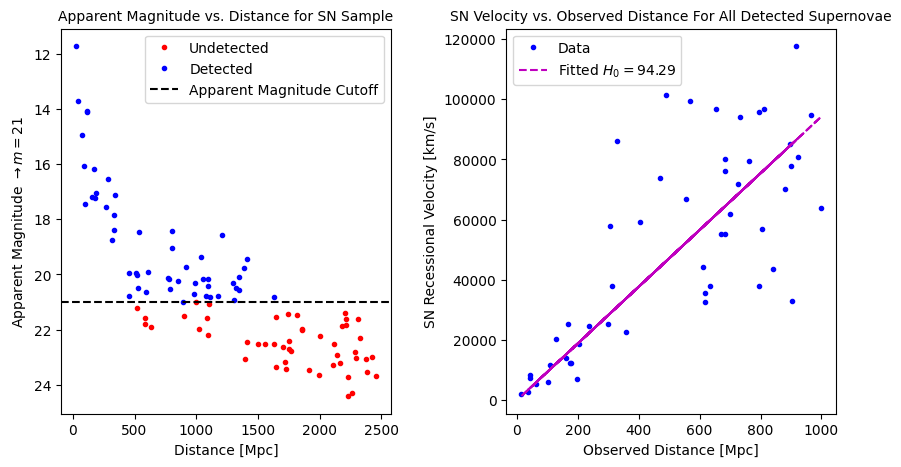

In [16]:
DoProblem2(100)

### N = 1000

The mean true distance of the supernovae is 1224.54 Mpc.
The average apparent magnitude of the original sample is 20.62.
The average apparent magnitude of the detected sample is 18.71.


C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\1320651643.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detect_SN_df["Velocity [km/s]"] = SN_vels
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\1320651643.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detect_SN_df["Obs Distance [Mpc]"] = 10 * 10**((SN_df["App Mag"] - (-19))/5) * 10**(-6)


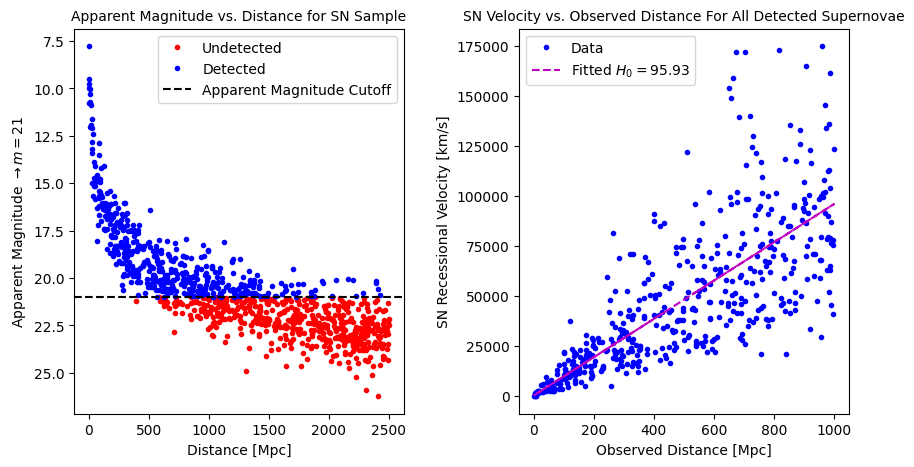

In [17]:
DoProblem2(1000)

### N = 10000

The mean true distance of the supernovae is 1257.91 Mpc.
The average apparent magnitude of the original sample is 20.84.
The average apparent magnitude of the detected sample is 18.82.


C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\1320651643.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detect_SN_df["Velocity [km/s]"] = SN_vels
C:\Users\iamac\AppData\Local\Temp\ipykernel_21668\1320651643.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detect_SN_df["Obs Distance [Mpc]"] = 10 * 10**((SN_df["App Mag"] - (-19))/5) * 10**(-6)


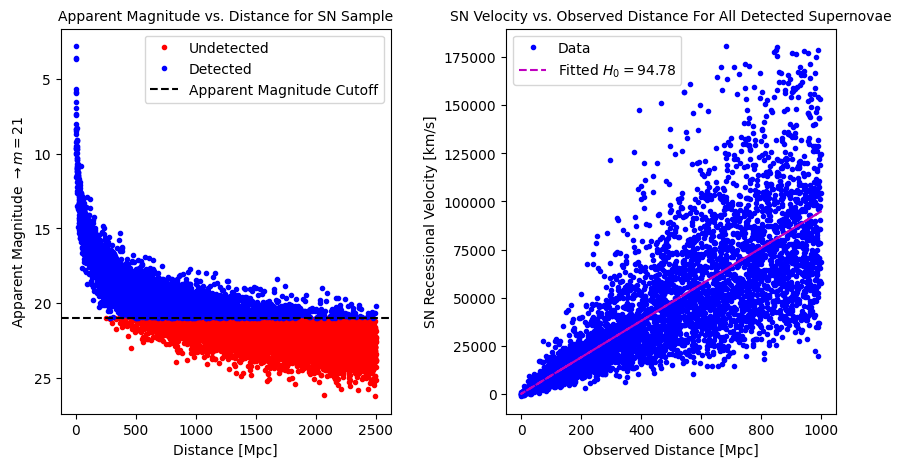

In [18]:
DoProblem2(10000)

### Short-Answer Components to Problem 2

P2.3) The true distance is always smaller than the observed distance. This is because we are biased towards seeing the brightest supernovae at a given distance. Recall that we generated the true absolute magnitudes via a distribution centered around a mean of $M=-19$ but with a Gaussian correction (with mean = 0 and standard deviation = 1 absolute magnitude). Because of Malmquist bias (biased towards detecting brighter objects at any given distance), we are biased towards detecting the supernovae which had a negative Gaussian correction (i.e. were randomly drawn to be brighter than $M=-19$). However, we assumed that $M=-19$ in calculating the observed distances. Recall the distance modulus formula:

$$m-M = 5\log_{10}(d/10pc) \longrightarrow (d/10pc) = 10^{(m-M)/5}$$

Therefore, the fact that we are assuming the absolute magnitude to be less negative than "the truth" (i.e. since we did not account for Malmquist bias), we end up underestimating the distance.

P2.4) Clearly, Malmquist bias is at play here (our fitted $H_0$ values are quite far off from the currently accepted range of $68\rightarrow 74 km/s/Mpc$). As shown on the plots where I fit $H_0$, the spread of points above the best-fit line is always greater than the spread of points below the best-fit line. This is indicative of the fact that we are biased towards detecting brighter objects at any given redshift. Further confirmation of the presence of Malmquist bias is that this effect does not really change much at all as we increase the number of supernovae; Malmquist bias is a systematic error and therefore should not depend on sample size. The complete lack of dependence on the sample size (i.e. the best fit $H_0$ is almost exactly the same even as we increase the number of supernovae by 2 orders of magnitude) indicates that peculiar velocity effects are minimal in relation to the Malmquist bias. Recall that peculiar velocity induces errors in Hubble constant fits by "perturbing" (this perturbation can be significant at low redshifts, where the cosmological expansion velocity is small) the cosmological recessional velocity; the error then arises in the fact that we assume the total velocity (cosmological + peculiar) to be purely cosmological in nature when fitting $H_0$ via a Hubble plot. Since this error-inducing perturbation (i.e. the peculiar velocity) is randomly drawn from a Gaussian distribution, increasing the sample size should cause the mean perturbation/peculiar velocity to tend towards 0 --- thereby decreasing the error in our $H_0$ fit. However, this is not observed; in fact, the fitted $H_0$ does not really change at all as we increase sample size --- indicating that the Malmquist bias is the dominant effect. We can account for this Malmquist bias by injecting sources below the apparent magnitude cutoff at each distance such that the distribution of supernovae absolute magnitudes at each distance is Gaussian again -- i.e. matching the distribution used to generate the full sample.

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!